In [88]:
import os
import sys
import csv
import copy
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import logging

# Make sure you've got Numpy and Scipy installed:
import numpy as np
import scipy
import scipy.spatial.distance
from six import iteritems, itervalues, string_types

# Visualization eff-yeah
import matplotlib.pyplot as plt

# word2vec
import gensim
import fileinput
from glob import glob

# For cleaning HTML mined data
from bs4 import BeautifulSoup as soup

# Regex
import re

In [4]:
%matplotlib inline

## Distributional Matrices

We can start by creating a dictionary $d$ that can be used to map word-pairs to counts. Everytime a pair of words $w$ and $w^\prime$ occur, we can increment a counter associated with each pair $d[w,w^\prime]$ by $1$. Using these count dictionary we can then create our vocabulary $V$, an ordered list of words types.

We can then create a matrix, $M$, of dimensions $|V|$ x $|V|$. Each $M[i,j]$ is filled with the counts contained in $d[w_i,w_j]$.

These co-occurence matrices have been provided with this example. We can import them with the _build_ function seen below.

In [5]:
# Build method to import co-occurence matrices

def build(src_filename, delimiter=',', header=True, quoting=csv.QUOTE_MINIMAL):    
    reader = csv.reader(open(src_filename), delimiter=delimiter, quoting=quoting)
    colnames = None
    if header:
        colnames = reader.__next__()
        colnames = colnames[1: ]
    mat = []    
    rownames = []
    for line in reader:
        rownames.append(line[0])            
        mat.append(np.array(list(map(float, line[1: ]))))    
    return (np.array(mat), rownames, colnames)


We can now read in the example co-occurency matrices for later. We will be using the IMDB moview review dataset for these examples.


In [6]:
# Import word <-> word co-occurence matrix
ww = build('distributedwordreps-data/imdb-wordword.csv')

#Import w <-> document co-occurence matrix
wd = build('distributedwordreps-data/imdb-worddoc.csv')

In [7]:
ww[0][0][0]

343744.0

In [8]:
# Example of counts of first words in the document which happen to be two exclamation marks

print("Word co-occurences : " + ww[1][0] + ", and, " + ww[2][0])

print("Count : " + str(ww[0][0][0]))

Word co-occurences : !, and, !
Count : 343744.0


In [9]:
# Load GloVe vectors as well

glv = build('distributedwordreps-data/glove.6B.50d.txt', delimiter=' ', header=False, quoting=csv.QUOTE_NONE)

# Vector Comparisons

For the most part we are interested in measuring the _distance_ between two vectors. The general idea of vector comparisons using distance is that words that are semantically similar should be closer together in the vector spaces we build, and symantically unrelated words should be further apart.

The scipy library has a lot of vector comparison models methods, and for the purposes of our work here we'll be using this library as a supporting implementation of these methods.

### Euclidean Distance

The first comparison methodology we'll look at is Euclidean Distance. To find this distance, 

The equation to find the Euclidean Distance between vectors $u$ and $v$ of $n$ dimensions is below :

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$


In two dimensions, this corresponds to the length of the direct most line between the two points.

Below is a method to define that function :

In [10]:
# method to compute euclidean distance
# we exploit a method already defined in scipy

def euclidean(u, v):
    return scipy.spatial.distance.euclidean(u, v)

Here I create a small toy array (matrix) for use within our examples.

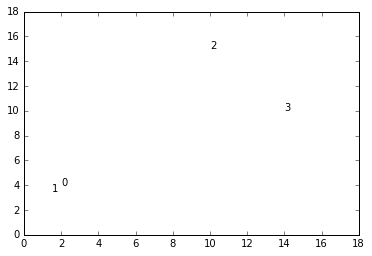

In [11]:
# Two dimensional vector embedding in two dimensional space to show 
# how we can measure the distance between two vectors in 2 space

ABC = np.array([
    [ 2.0,  4.0],  # 0
    [ 1.50, 3.50], # 1
    [10.0, 15.0],  # 2
    [14.0, 10.0]]) # 3

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['0','1','2','3']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

In [12]:
#Measure the distance between vectors A and B in matrix ABC
euclidean(ABC[0], ABC[1])

0.7071067811865476

In [13]:
#Measure the distance between vectors B and C in matrix ABC
euclidean(ABC[0], ABC[1])

0.7071067811865476

## Vector Length

Euclidean distance measures the difference between two vector lengths, as shown the in the equation above. We're also able to find the length of a single vector, for use in later examples, as well by using the following equation :

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$

We use the numpy library sqrt and dot product methods within the library shown below.

In [14]:
def vector_length(u):
    return np.sqrt(np.dot(u, u))

## Length Normalization

When working with datasets that have large(r), variation in the size of the datapoints that are used can skew the actual distance measured between vectors. Below we define a normalization function that will normalize each vector according to its length.

When normalizing all vectors according to their length, we can see in the plot below that this changes the representation of the data quite and bit and actually brings vector 0 and 1 closer together on the plot, showing their stronger similarity than say vectors 2 and 3, or 0 and 3.

In [15]:
def length_norm(u):
    return  u / vector_length(u)

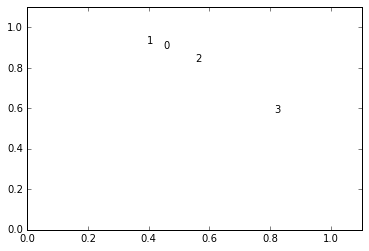

In [16]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

### Cosine Distance

The cosine distance takes the overall vector length into account, meaning we don't have to run the vector_length() method over the vectors before calculation, and measure the angle between the two vectors. This is all captured within the Cosine Distance measurement function that is seen below :

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The result is the same as first normalizing the vectors according to their length, vector_length(), and then computing the Euclidean distance between the two.

One thing to note with respect to Cosine Distance, is it should be viewed as the Cosine Similarity complement in positive space, such that :

$$D_{c}(A,B) = 1 - S_{c}(A,B)$$

Meaning that the cosine distance is a proper distance metric, which is not the case for Cosine Similarity as it does not have the triangle inequality property. This, however, is not necessarily an important property for the operations we'll be performing.[5]

In [17]:
def cosine(u, v):
    # Use scipy's method:
    return scipy.spatial.distance.cosine(u, v)

In [18]:
cosine(ABC[1],ABC[3])

0.14521248477827109

## Distributional Neighbors

This functional is an investigational aide and allows us to use the similarity functions defined above over the IMDB dataset that we've previously loaded.

This function is performing a cosine similarity computation ranking the _rownames_ according to their distance from _word_, as measured by the distfunc in matrix mat.

The function returns a sorted list of words that ascend from the closest, distance wise, depending on which distance method is passed in. The method defaults to using the cosine distance measurement.

In [19]:
def neighbors(word=None, mat=None, rownames=None, distfunc=cosine):
    if word not in rownames:
        raise ValueError('%s is not in this dataset' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

The neighbors method above might be a bit confusing, as its performing the cosine calculation over all vectors of co-occurences, per pair, within the dataset that's provided. And returning a sorted list of closest words to the input word.

That said, here I provide a simple single word comparison that is then extrapolated across all words in the co-occurance matrix, within the neighbors function.

In [20]:
w1 = ww[0][ww[1].index('superb')]

w2 = ww[0][ww[1].index('wonderfully')]

print("The vector representation for w1 is : " + str(w1))

print("The vector representation for w2 is : " + str(w2))

print("The cosine distance between vectors w1 and w2 is : " + str(cosine(w1, w2)))

The vector representation for w1 is : [ 381.   11.    4. ...,    7.    0.    1.]
The vector representation for w2 is : [ 207.    1.    5. ...,    2.   13.   10.]
The cosine distance between vectors w1 and w2 is : 0.00294731059371


Breaking this down even further, instead of allowing the cosine distance function to perform the normalization, and Euclidean distance calculations, we can do it by hand.

In [21]:
# Generic manual calculation of the Euclidean distance with the dot product of both vectors divided by
# the length of the vectors, also known as the L2 norm of those vectors
manual = 1.0 - (np.dot(w1, w2) / (vector_length(w1) * vector_length(w2)))

manual

0.0029473105937050104

Here we show an example of a word and their respective neighbors according to both cosine similarity and basic euclidean distance.

In [22]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 10]

[('superb', 0.0),
 ('excellent', 0.0026965023912962627),
 ('outstanding', 0.0027344413235226295),
 ('beautifully', 0.0027345163104325332),
 ('brilliant', 0.0027888643627086429),
 ('performances', 0.0028333319740448948),
 ('perfectly', 0.0028436893209292657),
 ('memorable', 0.0028935533453889883),
 ('cinematography', 0.0029206920379420964),
 ('wonderfully', 0.0029473105937050104)]

In [23]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 10]

[('superb', 0.0),
 ('familiar', 1448.8919904533948),
 ('violent', 1630.3723501090174),
 ('follows', 1647.0276257549538),
 ('convincing', 1701.2260284865147),
 ('pace', 1748.1195611284716),
 ('recent', 1769.8525362300668),
 ('amount', 1783.1822677449436),
 ('impressive', 1789.4510331383756),
 ('masterpiece', 1849.5091240650856)]

### GloVe representation

Here we can see that the GloVe vectors perform _very_ well, but they are based on much more than a simple raw count of occurences in the text.

In [24]:
neighbors(word='superb', mat=glv[0], rownames=glv[1], distfunc=cosine)[: 10]

[('superb', -4.4408920985006262e-16),
 ('brilliant', 0.15809110259014736),
 ('impressive', 0.19352861376442632),
 ('masterful', 0.22871323564771895),
 ('excellent', 0.22928471014596674),
 ('volley', 0.24414121851443749),
 ('deft', 0.24755074890723616),
 ('dazzling', 0.26191184828838354),
 ('score', 0.26231230884814061),
 ('scoring', 0.26641165920991983)]

## Matrix Reweighting

Taking a look at the similarity measurements listed above, we can see that they offer some insight into the embedded context contained within written language, but they're not quite as accurate as we would like them to be. This is where matrix reweighting comes into play. The goal of matrix reweighting is to amplify the important, trustworthy and unusual representations found within language, and de-emphasize the unimportant, and untrustworthy representations.

### Normalization

Here we see another form of normalization that can be applied to the data. With length_norm() seen above, we normalize using the vector_length(). There are other ways that we can normalize the datasets as well, such as each row by the sum of its values, which turns each row into a probability distribution over the columns :

In [25]:
def prob_norm(u):
    return u / np.sum(u)

It should be noted, however, that these normalization measures are insensitive to the magnitude of the underlying counts, which can cause problems in larger datasets. An example is [1,10] is vastly different than [1000, 10000], and those differences will end up being obscured by these normalization procedures.

### Pointwise Mutual Information [1]

This brings us to something called Pointwise Mutual Information (PMI), which can help address the issue of the ignorance of the magnitude of the counts within the previous normalization functions. This is the measure between a pair of discreet outcomes $x$ and $y$, as defined as :

$$PMI(x,y) = \log \frac{P(x,y)}{P(x) \cdot P(y)}$$

$PMI(w,c)$ measures the association between a word $w$ and a context $c$ by calculating the log of the ratio between their joint probability (the frequency in which they occur together) and their marginal probabilities (the frequency with which they occur independently).

This can be shown by considering the actual number of observations within a corpus :

$$PMI(w,c) = \log \frac{\#(w,c) \cdot |D|}{\#(w) \cdot \#(c)}$$

The challenge with PMI arises when we compute $M^{PMI}$. This leaves us with rows containing many entries of word-context pairs $(w,c)$ that were never observed in the corpus, for which $PMI(w,c) = \log 0 = -\infty$. This leaves the matrix 'ill-defined'. We could do potentially smooth over the probabilities using something like a Dirichlet prior by adding a small "fake" count to the underlying counts matrix. But this leaves us with, still, a very dense matrix to deal with.

An alternative approach would be to replace $M^{pmi}$ with $M_0^{PMI}$, in which $PMI(w,c) = 0$ in all cases $\#(w,c) = 0$, which results in a sparse matrix.

When approaching this problem, we understand that there are "bad" (uncorrelated) word-context pairs, which are represented with negative matrix entries, and replacing $M^{PMI}$ with $M_0^{PMI}$ will leave non-existent word context pairs with 0 entries in the matrix, which would rate them "better" than resulting negative entries from the real $M^{PMI}$.

### Positive Pointwise Mutual Information [1]

To get around the problem framed above, where uncorrelated word-context pairs will have negative matrix entries whereas zeroed out entries would exist for non-existent word-context pairs, we're able to a modification to the PMI algorithm called Positive Pointwise Mutual Information (PPMI). This will map all negative values within the matrix to 0.0, leveling the playing field between unseen word-context pairs and negative valued entries within the matrix. We can view this new positive PMI matrix as $M^{PPMI}$.

$$ PPMI(w,c) = \max(PMI(w,c),0) $$

Below we capture both implementations, PMI and PPMI. The positive argument default to True, implementing PPMI, if this argument is set to False, it will perform regular PMI.

It's interesting to note that the PMI matrix $M^{PMI}$ is what emerges as the optimal solution for SGNS, as seen below.

In [26]:
#PMI example
def pmi(mat=None, rownames=None, positive=True):
    # Create a joint probability table
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so it can be applied rowwise
    np_pmi_log = np.vectorize((lambda x : _pmi_log(x, positive=positive)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])
    return (p, rownames)

def _pmi_log(x, positive=True):
    """Where positive = False, return log(x) if possible, else 0.
    Where positive = True, log(x) is mapped to 0 where negative."""
    # set val var to 0.0
    val = 0.0
    # conditional 
    if x > 0.0:
        val = np.log(x)
    if positive:
        val = max([val, 0.0])
    return val
    

In [27]:
# Process the ww data using PPMI
ww_ppmi = pmi(mat=ww[0], rownames=ww[1], positive=True)

In [28]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[: 10]

[('superb', -2.2204460492503131e-16),
 ('excellent', 0.41348274842943578),
 ('performances', 0.4439162856870249),
 ('brilliant', 0.45785117509986151),
 ('performance', 0.46856555779383202),
 ('outstanding', 0.48315645713600386),
 ('beautifully', 0.48570217706133567),
 ('stunning', 0.48653666411656982),
 ('as', 0.4896847339821726),
 ('brilliantly', 0.48998750813252601)]

And again with Euclidean distance measure :

In [29]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=euclidean)[: 10]

[('superb', 0.0),
 ('excellent', 12.876470234708654),
 ('great', 13.475381696026227),
 ('performances', 13.604470031275069),
 ('as', 13.805235205825177),
 ('performance', 13.826597314820859),
 ('role', 13.84978951697956),
 ('cast', 13.925190826368734),
 ('brilliant', 13.932513494981505),
 ('story', 13.940602382288677)]

## Skipgram Negative Sampling (SGNS)

### Skipgram Model

The skipgram model assumes a corpus of words $w \in V_{w}$ and their contexts $c \in V_{c}$, where $V_w$ and $V_c$ are word and context vocabularies. The context vacabulary was assembled using an _L_-sized window $w_{i-L}...,w_{i-1}, w_{i+1}...,w_{i+L}$. 

The objective of the skipgram model is to maximize the average log probability, where $c$ is the size of the training context, seen as a function of the center word $w_{i}$.

As an example, say we set the window size to a count of 3, using the example sentence below, "The quick brown fox jumped over the lazy dog", if we choose 'jumped' as our word of interest, we can add it to $V_{w}$. After adding 'jumped' the the word vector, we can use the window function to capture the surrounding words by simply counting forward and backward through the sentence and append each word to $V_{c}$.

<img src="SGNSwindow.jpg">

We denote the collection of observed word context pairs, $(w,c)$, as $D$. We also use $\#(w,c)$ to denote the number of times observe $(w,c)$ in $D$.

### SGNS Objective

The objective of Skipgram with Negative Sampling is to maximize the the probability that $(w,c)$ came from the data $D$. This can be modeled as a distribution such that $P(D=1|w,c)$ be the probability that $(w,c)$ came from the data and $P(D=0|w,c) = 1 - P(D=1|w,c)$ the probability that $(w,c)$ did not. 

The distribution is modeled as :

$$P(D=1|w,c) = \sigma(\vec{w} \cdot \vec{c}) = \frac{1}{1+e^{-\vec{w} \cdot \vec{c}}}$$

where $\vec{w}$ and $\vec{c}$ (each a d-dimensional vector) are the model parameters to be learned.

The negative sampling tries to maximize $P(D=1|w,c)$ for observed $(w,c)$ pairs while maximizing $P(D=0|w,c)$ for stochastically sampled "negative" examples, under the assumption that selecting a context for a given word is likely to result in an unobserved $(w,c)$ pair.

SGNS's objective for a single $(w,c)$ observation is then:

$$ \log \sigma(\vec{w} \cdot \vec{c}) + k \cdot \mathbb{E}_{c_{N} \sim P_{D}} [\log \sigma(\vec{-w} \cdot \vec{c}_N)] $$

where $k$ is the number of "negative" samples and $c_{N}$ is the sampled context, drawn according to the empirical unigram distribution $P_{D}(c) = \frac{\#c}{|D|}$.

This object is then trained in an online fashion using stochastic gradient updated over the observed pairs in the corpus $D$. The goal objective then sums over the observed $(w,c)$ pairs in the corpus :

$$ \ell = \Sigma_{w \in V_{w}} \Sigma_{c \in V_{c}} \#(w,c)(\log \sigma(\vec{w} \cdot \vec{c}) + k \cdot \mathbb{E}_{c_{N} \sim P_{D}} [\log \sigma(\vec{-w} \cdot \vec{c}_N)]$$

Optimizing this objective groups words that have similar embeddings, while scattering unobserved pairs.

Tying the two of these together, we can see that SGNS with $k = 1$ is attempting to implicity factorize the familiar matrix $M^{PMI}$.

Past re-implementing word2vec and all of the hyperparameters that have been discussed here, we can defer to the word2vec implementation that exists within the library gensim.

Within gensim are two implementations of word2vec, both hierachical softmax and negative sampling. 

In order for us to be able to show how the skip-gram model, and ultimately negative sampling combined with skip-gram, works we will need an unprocessed dataset. We can see below how to import that and ready it for processing.

In [30]:
# Method used to import raw data
def import_raw_data(directory):
    corpora = []
    filenames = glob(directory)
    # Read each file in as a separate line
    for line in fileinput.input(filenames):
        corpora.append(line)
    return corpora

# Clean review of HTML tags, punctuation, etc.

def clean_review(reviews):
    corpora = []
    for i in reviews:
        # Clean HTML
        review_text = soup(i, "html.parser")
        # Clean punctuation
        letters_only = re.sub("[^a-zA-Z0-9]", " ", review_text.get_text())
        # Split into individual words and convert to lower_case
        words = letters_only.lower().split()
        # Join words back together removing extreanous whitespacing
        corpora.append(( " ".join(words)))
    return corpora

In [31]:
raw_comments = import_raw_data('aclImdb/train/unsup/*.txt')

In [32]:
clean_example = clean_review(raw_comments)

print(clean_example[0])

i admit the great majority of films released before say 1933 are just not for me of the dozen or so major silents i have viewed one i loved the crowd and two were very good the last command and city lights that latter chaplin circa 1931 so i was apprehensive about this one and humor is often difficult to appreciate uh enjoy decades later i did like the lead actors but thought little of the film one intriguing sequence early on the guys are supposed to get de loused and for about three minutes fully dressed do some schtick in the background perhaps three dozen men pass by all naked white and black wwi and for most their butts part or full backside are shown was this an early variation of beefcake courtesy of howard hughes


In [33]:
# Split sentences into words for tokenization within word2vec
corpora = []
for s in clean_example:
    words = s.split()
    corpora.append(words)

We can now train a model according to the data that we have from the IMDB dataset, using the word2vec implementation within gensim. I will also expose some of the underbelly of the gensim implementation of word2vec to help illustrate the data manipulation going on 'under the hood' of the implementation. I am doing this as gensim has a rather mature implementation of word2vec, adapted from the original code from Google (http://word2vec.googlecode.com/svn/trunk/word2vec.c), which is far more mature, stable, and usable than what I could produce in a reasonable amount of time.

Below we see we're defining a model object, in which we call the Word2vec class from gensim, passing in a few arguments :

* corpora -- this is the dataset we've defined
* min_count -- this is the minimum count of any given word within the corpora that we're passing in, if the count is below this, the word will be discarded from the vocabulary
* window -- This is the context window that is used to capture context surrounding a given word $w_{i}$ for $V_{c}$ as represented above
* workers -- this is the number of worker threads that will be used to train (can mean faster training times with more cores)

min_count and window are both hyperparameters for this model and can change the accuracy of our results, but we'll get into that later. What I want to provide here is a little intuition as to what is going on, mathematically.

One thing to keep in mind with the gensim implementation of word2vec, when calling similarity functions like this, is there is an init_sims() method that is invoked at the beginning of the similarity methods. If the 'replace' argument is set for this method, it will perform an optimization for memory consumption within the model. It will return the L2-normalized vectors of each word, instead of maintaining the entire vector representation in memory. 

Again, represented as :

$$\|v\| = \sqrt{\sum_{i=1}^{n} v_{i}^{2}}$$

This will effectively make the model "read-only", and can't continue 'training' it. Something to keep in mind if you'd like to save some resources on your machine if you're working through larger datasets using this write-up as an example.

In [37]:
model = gensim.models.Word2Vec(corpora, min_count=5, window=15, workers=4, negative=5)

Let's break this down step by step for a single comment, much like the one we printed above to validate out text parsing and formatting functions. For simplicity and robustness of the example, we'll start with a word that is further along in the sentence than the first word. This will help illustrate the windowing in a little more detail as well.

First we'll need to create a few table objects to house some of the required data that we'll be using in our operations, such as total_word count, the vocab

Keep in mind this example will be _very_ limited in its functionality as word2vec is designed to run over large corpora - that's where the algorithms power comes in, is with more data. :)

In [91]:
# Carve off 20 words from the first sentence contained 
# within the corpora object above
play_corpora = corpora[0]

# Create raw vocabulary from given corpus (will be small
# according to limited vocabulary we've carved off our
# full corpus)

total_words = 0

vocab = defaultdict(int)

for word in play_corpora:
        vocab[word] += 1
        
total_words += sum(itervalues(vocab))

In [67]:
dtype = np.dtype

vocab_size = len(play_corpora)

# Create cumulative table of word counts

cum_table = np.zeros(vocab_size, dtype=np.uint32)

We can also manually compute the cosine similarity between two word vectors that have been created using the word2vec model.

In [120]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[: 10]

[('superb', -2.2204460492503131e-16),
 ('excellent', 0.41348274842943578),
 ('performances', 0.4439162856870249),
 ('brilliant', 0.45785117509986151),
 ('performance', 0.46856555779383202),
 ('outstanding', 0.48315645713600386),
 ('beautifully', 0.48570217706133567),
 ('stunning', 0.48653666411656982),
 ('as', 0.4896847339821726),
 ('brilliantly', 0.48998750813252601)]

## References

[1] Omar Levy, Yoav Goldberg. Neural Word embedding as Implicit Matrix Factorization. NIPS, 2015

[2] Omar Levy, Yoav Golderg. word2vec Explained: Deriving Mikolov et al.’s Negative-Sampling Word-Embedding Method

[3] Omar Levy, Yoav Goldber, Ido Dagan. Improving Distributional Similarity with Lessons Learned from Word Embeddings

[4] Tomas Mikolov, Ilya Sutskever, Kai Chen, Gregory S. Corrado, and Jeffrey Dean. Distributed representations of words and phrases and their compositionality.

[5] Cosine Similarity https://en.wikipedia.org/wiki/Cosine_similarity